# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional: Análise de Imagens Médicas

> Atenção: este notebook foi desenhado para funcionar no **Google Collab**.


## 1. Introdução

Uma determinada fintech focada em consumidores finais pessoa física constataou um grande número de fraudes em transações bancárias.

O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços específicos, como o crédito pessoal, e após isso transferir para outras contas desconhecidas. 

Após análises pelas equipes de segurança, os protocolos de utilização da senha foram realizados em conformidade, ou seja, cada cliente autenticou com sua própria senha de maneira regular.

Em função disso, o banco precisa arcar com reembolsos e medidas de contenção para evitar processos judiciais, pois os clientes alegam terem sido invadidos por hackers ou algo parecido.

Uma das formas de solucionar ou minimizar este problema é com a utilização de outras formas de autenticação, sobretudo em operações críticas, como a obtenção de crédito pessoal.

Desta forma podemos implementar uma verificação de identidade com prova de vida (liveness), que utilize uma verificação e identificação facial. 

Caso o cliente não seja autenticado, ele será atendido por uma esteira dedicada e as evidências da não identificação serão encaminhadas para a área de IA para validação dos parâmetros e limiares para aperfeiçoamento do modelo.

Será necessário construir:

* Detector de faces
* Identificação de faces (podendo ser um comparador entre um rosto de documento e outra da prova de vida)
* Detecção de vivacidade (liveness) para evitar que um fraudador utilize uma foto estática.


>Formas alternativas de prover a identificação e prova de vivacidade, além destas que foram solicitadas poderão ser submetidas.


<p align="center">
    <img src="imagens/liveness.jpg">
</p>

Imagem retirada do [Grunge](https://www.grunge.com/192826/company-testing-robocop-facial-recognition-software-with-us-police/).

## 2. Instruções

Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas.

Iremos constuir uma forma de validar se uma determinada imagem foi ou não adulterada e se trata de uma produção fraudade.

Existem diversas formas de validar a vivacidade, e neste sentido conto com a criatividade de vocês dado que já dominam encontrar uma face numa imagem, aplicar marcos faciais e até mesmo construir uma rede neural convulacional.

A abordagem mais simples é pela construção de uma rede neural com imagens de fotos de rostos de outras fotos e fotos de rostos sem modificações. Tal classificador deverá classificar se dada imagem possui vivacidade ou não com uma pontuação de probabilidade.

Referências que abordam o tema para servir de inspiração:

1. [PyImageSearch](https://pyimagesearch.com/2019/03/11/liveness-detection-with-opencv/), Liveness detection with OpenCV;
2. [Kickertech](https://kickertech.com/face-liveness-detection-via-opencv-and-tensorflow/), Liveness detection via OpenCV and Tensorflow.
3. [Towards Data Science](https://towardsdatascience.com/real-time-face-liveness-detection-with-python-keras-and-opencv-c35dc70dafd3?gi=24f8e1b740f9), Real-time face liveness detection with Python, Keras and Opencv2.

Este projeto poderá ser feita por grupos de até 4 pessoas.
Caso este projeto seja substitutivo, deverá ser realizado por apenas uma pessoa.

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :-------------| :-----: |
| Vinícius Marcili         | RM 345167      | 1IAR |
| Guilherme             | RM 346006      | 1IAR |
| Fabiana            | RM 345858      | 1IAR |

## 3. Abordagem e organização da solução do problema (2 pontos)

Como o grupo pretende deteccar a prova de vivacidade de uma determinada imagem? Quais os passos e os building blocks deste processo?

**Resposta**: 

## 4 Desenvolvimento da solução (5,5 pontos)

Detalhe o passo-a-passo do algoritmo de deteção de vivacidade.
Se optar pela construção e treinamento de um modelo de redes neurais convulucionais, apresente a arquitetura, prepare os dados de treinamento, realize o treinamento.

### 4.1 Organização de dados para treinamento de modelo de liveness (2 pontos)

In [57]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn import preprocessing
import cv2
from tqdm import tqdm
from sklearn.metrics import accuracy_score
%matplotlib inline

In [58]:
# Definindo um tamanho para padronizar as imagens
IMAGE_SIZE = [192, 192]
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE

In [59]:
# Instanciando classificador de faces
haarcascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [60]:
# Pegando todas as imagens da pasta samples
images = []
for dirname, _, filenames in os.walk('samples'):
  for filename in filenames:
    images.append(os.path.join(dirname, filename))
images = pd.DataFrame(images, columns=['filenames'])

In [61]:
# Atribuindo o nome da pessoa ao caminho da imagem e o tipo da imagem (real ou fake)
images['name'] = images['filenames'].apply(lambda x: x.split('/')[1])
images['type'] = images['filenames'].apply(lambda x: 'real' if 'Selfie' in x.split('/')[2].split('_')[0] else 'fake')
images.head(5)

,filenames,name,type
0,samples/Ewa/Selfie_9.jpg,Ewa,real
1,samples/Ewa/Selfie_1.jpg,Ewa,real
2,samples/Ewa/Selfie_5.jpg,Ewa,real
3,samples/Ewa/Selfie_10.jpg,Ewa,real
4,samples/Ewa/Selfie_2.jpg,Ewa,real


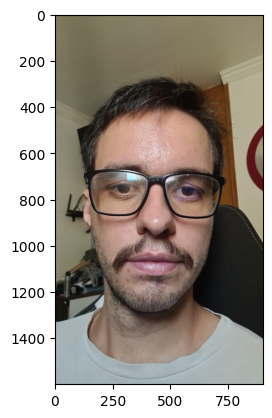

In [62]:
# Pegando uma imagem para testar o pré processamento
imagem = cv2.imread(images['filenames'][151])
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
plt.imshow(imagem)

In [63]:
# Função para extrair a face da imagem
def get_face(img):
  imagem_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = haarcascade.detectMultiScale(imagem_gray, 1.3, 5)
  
  if np.array_equal(faces, ()):
    return None
  
  for (x,y,w,h) in faces:
    result = img[y:y+h, x:x+w]
  
  return cv2.cvtColor(cv2.resize(result, IMAGE_SIZE, interpolation=cv2.INTER_LANCZOS4), cv2.COLOR_BGR2GRAY)

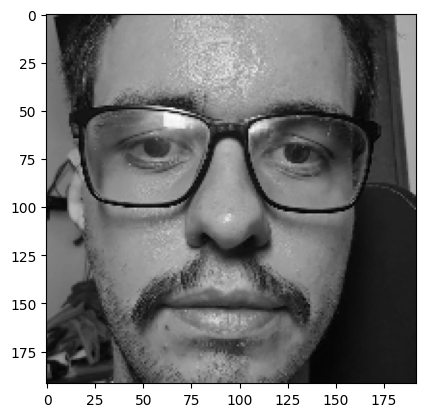

In [64]:
# Resultado
roi = get_face(imagem)
plt.imshow(roi, cmap="gray")

In [65]:
# Get only real images, extract face
images.loc[:, 'face'] = images['filenames'].apply(lambda x: get_face(cv2.imread(x)))
images = images.dropna()
images.head(5)

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

,filenames,name,type,face
1,samples/Ewa/Selfie_1.jpg,Ewa,real,"[[72, 68, 52, 74, 69, 76, 74, 80, 81, 69, 82, ..."
2,samples/Ewa/Selfie_5.jpg,Ewa,real,"[[175, 173, 172, 180, 176, 176, 180, 175, 176,..."
3,samples/Ewa/Selfie_10.jpg,Ewa,real,"[[131, 131, 134, 129, 129, 130, 129, 125, 130,..."
4,samples/Ewa/Selfie_2.jpg,Ewa,real,"[[186, 182, 184, 187, 186, 188, 182, 185, 187,..."
5,samples/Ewa/ID_2.jpg,Ewa,fake,"[[153, 153, 154, 154, 153, 151, 152, 150, 151,..."


In [80]:
images

,filenames,name,type,face
1,samples/Ewa/Selfie_1.jpg,Ewa,real,"[[72, 68, 52, 74, 69, 76, 74, 80, 81, 69, 82, ..."
2,samples/Ewa/Selfie_5.jpg,Ewa,real,"[[175, 173, 172, 180, 176, 176, 180, 175, 176,..."
3,samples/Ewa/Selfie_10.jpg,Ewa,real,"[[131, 131, 134, 129, 129, 130, 129, 125, 130,..."
4,samples/Ewa/Selfie_2.jpg,Ewa,real,"[[186, 182, 184, 187, 186, 188, 182, 185, 187,..."
5,samples/Ewa/ID_2.jpg,Ewa,fake,"[[153, 153, 154, 154, 153, 151, 152, 150, 151,..."
...,...,...,...,...
414,samples/Mykhailo/Selfie_13.jpg,Mykhailo,real,"[[97, 93, 84, 78, 75, 72, 69, 68, 68, 68, 67, ..."
415,samples/Mykhailo/Selfie_4.jpg,Mykhailo,real,"[[217, 216, 213, 216, 213, 212, 208, 201, 197,..."
416,samples/Mykhailo/Selfie_7.jpg,Mykhailo,real,"[[154, 156, 156, 154, 158, 154, 153, 153, 154,..."
417,samples/Mykhailo/Selfie_3.jpg,Mykhailo,real,"[[219, 201, 205, 213, 220, 220, 218, 216, 212,..."


In [79]:
# Duplicate data with mirror images
images2 = pd.concat([images, images], axis=0)
# images2[int(len(images)/2):]['face'] = images['face'].apply(lambda x: cv2.flip(x, 1))
images2

/tmp/ipykernel_26444/4246986986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  images2[int(len(images)/2):]['face'] = images['face'].apply(lambda x: cv2.flip(x, 1))


,filenames,name,type,face
1,samples/Ewa/Selfie_1.jpg,Ewa,real,"[[72, 68, 52, 74, 69, 76, 74, 80, 81, 69, 82, ..."
2,samples/Ewa/Selfie_5.jpg,Ewa,real,"[[175, 173, 172, 180, 176, 176, 180, 175, 176,..."
3,samples/Ewa/Selfie_10.jpg,Ewa,real,"[[131, 131, 134, 129, 129, 130, 129, 125, 130,..."
4,samples/Ewa/Selfie_2.jpg,Ewa,real,"[[186, 182, 184, 187, 186, 188, 182, 185, 187,..."
5,samples/Ewa/ID_2.jpg,Ewa,fake,"[[153, 153, 154, 154, 153, 151, 152, 150, 151,..."
...,...,...,...,...
414,samples/Mykhailo/Selfie_13.jpg,Mykhailo,real,"[[97, 93, 84, 78, 75, 72, 69, 68, 68, 68, 67, ..."
415,samples/Mykhailo/Selfie_4.jpg,Mykhailo,real,"[[217, 216, 213, 216, 213, 212, 208, 201, 197,..."
416,samples/Mykhailo/Selfie_7.jpg,Mykhailo,real,"[[154, 156, 156, 154, 158, 154, 153, 153, 154,..."
417,samples/Mykhailo/Selfie_3.jpg,Mykhailo,real,"[[219, 201, 205, 213, 220, 220, 218, 216, 212,..."


In [75]:
# mirror images
images.loc[:, 'mirror'] = images['face'].apply(lambda x: cv2.flip(x, 1))

,filenames,name,type,face
1,samples/Ewa/Selfie_1.jpg,Ewa,real,"[72, 68, 52, 74, 69, 76, 74, 80, 81, 69, 82, 7..."
1,samples/Ewa/Selfie_1.jpg,Ewa,real,"[62, 64, 64, 74, 74, 71, 76, 78, 74, 71, 81, 7..."
1,samples/Ewa/Selfie_1.jpg,Ewa,real,"[65, 71, 76, 74, 76, 76, 84, 69, 75, 74, 72, 7..."
1,samples/Ewa/Selfie_1.jpg,Ewa,real,"[67, 70, 71, 72, 73, 72, 73, 69, 77, 65, 67, 6..."
1,samples/Ewa/Selfie_1.jpg,Ewa,real,"[72, 77, 73, 71, 73, 69, 63, 64, 66, 60, 49, 5..."


In [66]:
def train_test_validation_split(dataset, dataset_size, train_split=0.7, val_split=0.15, test_split=0.15):
  assert (train_split + test_split + val_split) == 1
 
  train_size = int(train_split * dataset_size)
  val_size = int(val_split * dataset_size)

  train_ds = dataset[:train_size]
  val_ds = dataset[train_size:train_size + val_size + 1]
  test_ds = dataset[train_size + val_size + 1:]
  
  return train_ds, val_ds, test_ds

In [67]:
# total
images.__len__()

386

In [68]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(images['face'], images['name'], test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(308, 78, 308, 78)

In [69]:
# Convert y to array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [70]:
# convert to int 32
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_train = np.array([np.array(xi) for xi in X_train])
X_test = np.array([np.array(xi) for xi in X_test])

In [71]:
# Tranform names to numbers
le = preprocessing.LabelEncoder()
le.fit(list(set(images['name'])))
y_train_labels = le.transform(y_train)
y_test_labels = le.transform(y_test)

y_train_labels[0], y_train[0]

(12, 'Juliana')

### 4.2 Treinamento de modelo de liveness (1,5 pontos)

In [74]:
## Face Recognition
modelo_lbph = cv2.face.LBPHFaceRecognizer_create()
modelo_lbph.train(X_train, y_train_labels)
y_pred_lbph = []

for item in tqdm(X_test):
    y_pred_lbph.append(modelo_lbph.predict(item)[0])
    
acuracia_lbph = accuracy_score(y_test_labels, y_pred_lbph)
acuracia_lbph

100%|██████████| 78/78 [00:01<00:00, 41.18it/s]


0.6923076923076923

In [73]:
## test with image
imagem = cv2.imread('samples/Juliana/Selfie_10.jpg')
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
roi = get_face(imagem)

modelo_lbph.predict(roi)

(12, 38.55557329795083)

### 4.3 Métricas de desempenho do modelo (2 pontos)

## 5 Teste Fim-a-Fim

Simule a operação fim-a-fim, com uma imagem de entrada forjada (foto de foto de um rosto) e outra com uma imagem de rosto, exibindo o resultado da classificação e a pontuação de cada classe.

>Com a implementação da solução na forma de uma aplicação do [Streamlit](https://www.streamlit.io/) (veja a pata streamlit-app e use o template) vale 1 ponto adicional.

**Pergunta**: Se utilizou o Streamlit, compartilhe a URL do aplicativo publicado:

**Resposta**:

## 6 Conclusões (2,5 pontos)

**Pergunta**: Dado todo o estudo e pesquisa, quais foram as conclusões sobre a solução, o que funcionou, o que não funcionou e quais os detalhes que observariam numa nova versão e melhorias do processo?

**Resposta**: